In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from __future__ import print_function
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


In [2]:
train_data_dir = '/Users/mac/Desktop/AI/Facial Expression Recognition/archive/train'
validate_data_dir = '/Users/mac/Desktop/AI/Facial Expression Recognition/archive/test'

In [3]:
# Define the selected categories
selected_classes = ['happy', 'sad','surprise', 'neutral']
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Get indices of the selected categories
selected_indices = [class_labels.index(label) for label in selected_classes]

In [ ]:
def load_images(data_dir):
    image_paths = []
    labels = []

    for label in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label)
        if os.path.isdir(label_path) and label in selected_classes:  # تأكد من أنه من الفئات المختارة
            for file in os.listdir(label_path):
                if file.lower().endswith('.jpg'):
                    image_path = os.path.join(label_path, file)
                    image_paths.append(image_path)
                    labels.append(label)
                    
    # Shuffle the data and labels together
    image_paths, labels = shuffle(image_paths, labels, random_state=40)
    return image_paths, labels

In [5]:
# Load and shuffle train and validation
X_train_raw, y_train = load_images(train_data_dir)
X_val_raw, y_val = load_images(validate_data_dir)

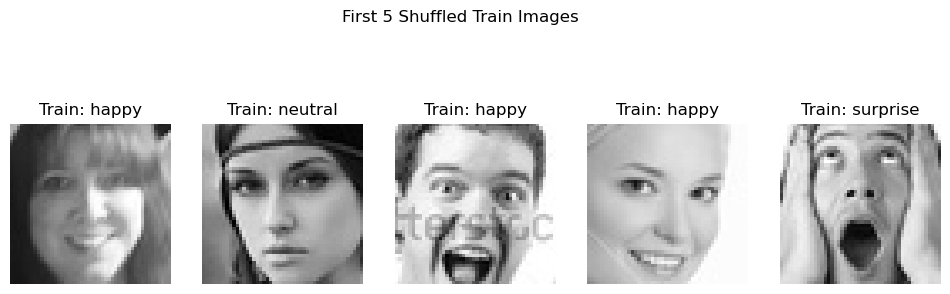

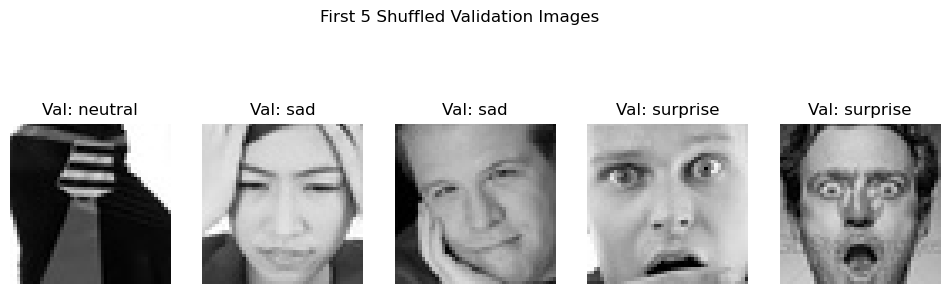

In [7]:
# Show first 5 from train
plt.figure(figsize=(12, 4))
for i in range(5):
    img = cv2.imread(X_train_raw[i], cv2.IMREAD_GRAYSCALE)  # تحميل الصورة من المسار
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((48, 48))  # تأكد أن الصورة موجودة
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Train: {y_train[i]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Train Images")
plt.show()

# Show first 5 from validation
plt.figure(figsize=(12, 4))
for i in range(5):
    img = cv2.imread(X_val_raw[i], cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if img is not None else np.zeros((48, 48))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Val: {y_val[i]}")
    plt.axis('off')
plt.suptitle("First 5 Shuffled Validation Images")
plt.show()

In [10]:
def preprocess_images(image_paths):
    processed = []
    for i, path in enumerate(image_paths):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        hist_eq = cv2.equalizeHist(img)
        denoised_img = cv2.fastNlMeansDenoising(hist_eq, h=15, templateWindowSize=7, searchWindowSize=21)
        sharpening_kernel = np.array([[0, -1, 0],
                                      [-1, 5, -1],
                                      [0, -1, 0]])
        sharpened = cv2.filter2D(denoised_img, -1, sharpening_kernel)
        alpha = 0.3
        blended = cv2.addWeighted(denoised_img, 1 - alpha, sharpened, alpha, 0)
        resized = cv2.resize(blended, (48, 48))
        normalized = resized.astype('float32') / 255.0

        processed.append(normalized)

        if i % 100 == 0:
            print(f"Processed {i}/{len(image_paths)} images...")

    return np.array(processed)

In [34]:
# Preprocess both train and validation
X_train = preprocess_images(X_train_raw)
X_val = preprocess_images(X_val_raw)

Processed 0/20181 images...
Processed 100/20181 images...
Processed 200/20181 images...
Processed 300/20181 images...
Processed 400/20181 images...
Processed 500/20181 images...
Processed 600/20181 images...
Processed 700/20181 images...
Processed 800/20181 images...
Processed 900/20181 images...
Processed 1000/20181 images...
Processed 1100/20181 images...
Processed 1200/20181 images...
Processed 1300/20181 images...
Processed 1400/20181 images...
Processed 1500/20181 images...
Processed 1600/20181 images...
Processed 1700/20181 images...
Processed 1800/20181 images...
Processed 1900/20181 images...
Processed 2000/20181 images...
Processed 2100/20181 images...
Processed 2200/20181 images...
Processed 2300/20181 images...
Processed 2400/20181 images...
Processed 2500/20181 images...
Processed 2600/20181 images...
Processed 2700/20181 images...
Processed 2800/20181 images...
Processed 2900/20181 images...
Processed 3000/20181 images...
Processed 3100/20181 images...
Processed 3200/20181

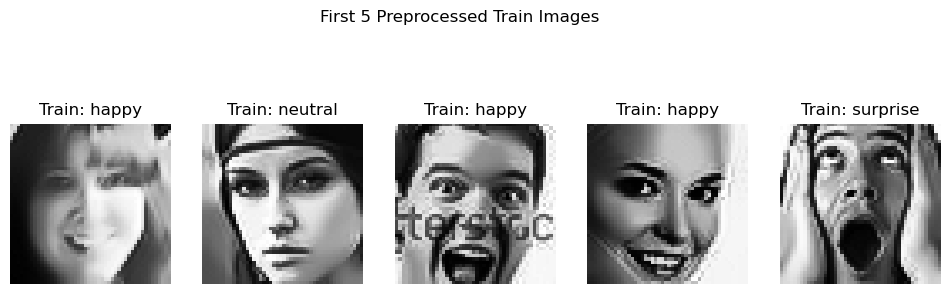

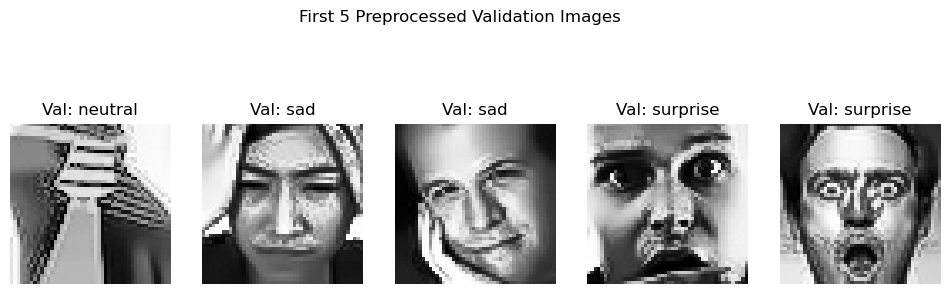

In [12]:
# Show first 5 preprocessed train images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Train: {y_train[i]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Train Images")
plt.show()

# Show first 5 preprocessed validation images
plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title(f"Val: {y_val[i]}")
    plt.axis('off')
plt.suptitle("First 5 Preprocessed Validation Images")
plt.show()

In [22]:
type(X_train), type(X_val), type(y_train), type(y_val)

(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)

In [19]:
from sklearn.preprocessing import LabelEncoder
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

In [27]:
from skimage.feature import hog, local_binary_pattern
from skimage.filters import prewitt, scharr, laplace, gabor
from skimage.restoration import denoise_tv_chambolle
import cv2
import numpy as np

def extract_features_from_image(img):
    # Ensure the image is in 2D grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img

    # Normalize image for OpenCV if needed
    if gray.max() <= 1:
        gray = (gray * 255).astype(np.uint8)

    # 1. Sobel Edge Detection
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel_edge = np.sqrt(sobelx**2 + sobely**2)

    # 2. Canny Edge Detection
    try:
        canny_edges = cv2.Canny(gray, 100, 200)
    except Exception as e:
        print(f"Error applying Canny edge detection: {e}")
        canny_edges = np.zeros_like(gray)

    # 3. HOG
    fd, hog_image = hog(gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

    # 4. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')

    # 5. Gaussian Blur
    blurred_img = cv2.GaussianBlur(gray, (5, 5), 0)

    # 6. Laplacian
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)

    # 7. Scharr
    scharr_edge = scharr(gray)

    # 8. Prewitt
    prewitt_edge = prewitt(gray)

    # 9. Median Filter
    median_filtered = cv2.medianBlur(gray, 5)

    # 10. Gabor Filter
    gabor_response, _ = gabor(gray, frequency=0.6)

    # Return all 2D feature images
    return (
        sobel_edge,
        canny_edges,
        hog_image,
        lbp,
        blurred_img,
        laplacian,
        scharr_edge,
        prewitt_edge,
        median_filtered,
        gabor_response
    )

# Dataset feature extraction (same as before)
def extract_features_for_dataset(X_data):
    all_features = []
    for img in X_data:
        img = img.reshape(48, 48)
        features = extract_features_from_image(img)
        all_features.append(features)
    return np.array(all_features)


In [28]:
# Assuming X_train and X_test are your training and test datasets
X_train_feat = extract_features_for_dataset(X_train)
X_val_feat = extract_features_for_dataset(X_val)

# Print shapes of the extracted feature sets
print(f"Shape of extracted features for X_train: {X_train_feat.shape}")
print(f"Shape of extracted features for X_test: {X_val_feat.shape}")

Shape of extracted features for X_train: (20181, 10, 48, 48)
Shape of extracted features for X_test: (5085, 10, 48, 48)


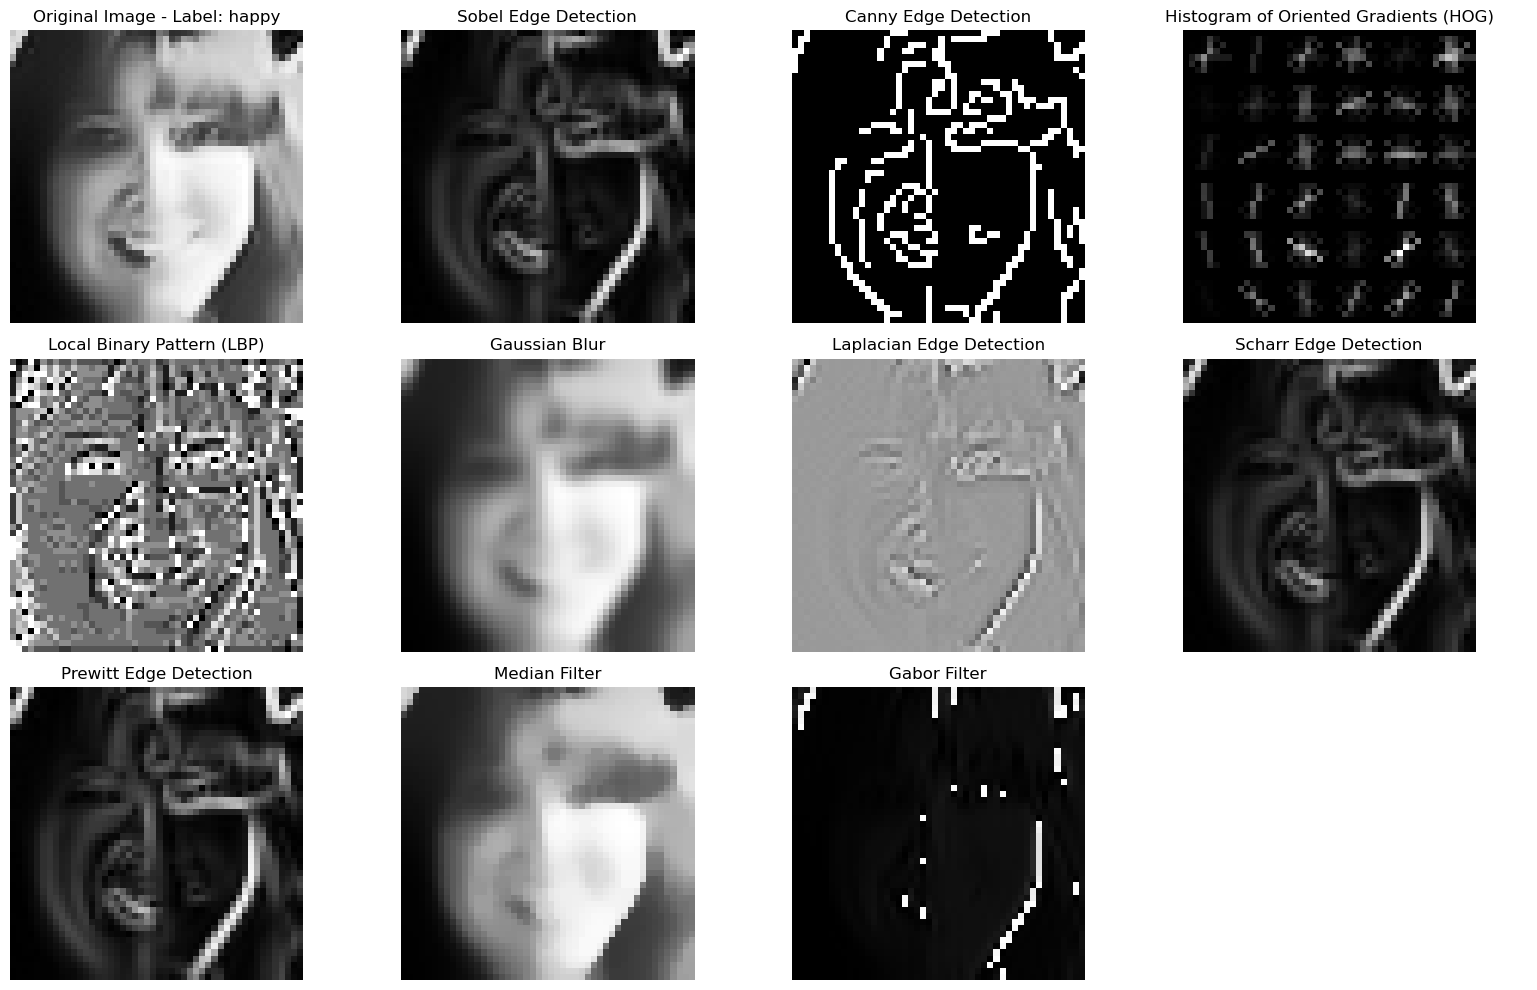

In [29]:
# First image and label
first_image = X_train[0].reshape(48, 48)
first_image_label = selected_classes[y_train[0]]

# Extract features (this function now returns 10 feature images)
features = extract_features_from_image(first_image)

# Titles for each feature
titles = [
    f"Original Image - Label: {first_image_label}",
    "Sobel Edge Detection",
    "Canny Edge Detection",
    "Histogram of Oriented Gradients (HOG)",
    "Local Binary Pattern (LBP)",
    "Gaussian Blur",
    "Laplacian Edge Detection",
    "Scharr Edge Detection",
    "Prewitt Edge Detection",
    "Median Filter",
    "Gabor Filter"
]

# Prepare figure with enough subplots (3 rows x 4 cols)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(16, 10))

# Flatten axes to loop easily
axes = axes.flatten()

# Plot original image first
axes[0].imshow(first_image, cmap='gray')
axes[0].set_title(titles[0])
axes[0].axis('off')

# Plot all feature maps
for i, feature_img in enumerate(features):
    axes[i + 1].imshow(feature_img, cmap='gray')
    axes[i + 1].set_title(titles[i + 1])
    axes[i + 1].axis('off')

# Hide any remaining unused subplots (if less than 12)
for j in range(len(features) + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [30]:
# Flatten the extracted feature set
X_train_feat_flattened = X_train_feat.reshape(X_train_feat.shape[0], -1)  # Flatten each sample
X_val_feat_flattened = X_val_feat.reshape(X_val_feat.shape[0], -1)  # Flatten each sample

# Print the new shape to verify
print(f"Shape of flattened features for X_train: {X_train_feat_flattened.shape}")
print(f"Shape of flattened features for X_test: {X_val_feat_flattened.shape}")


Shape of flattened features for X_train: (20181, 23040)
Shape of flattened features for X_test: (5085, 23040)


In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train_feat_flattened, y_train)

# Predict on the test data
y_pred = rf_model.predict(X_val_feat_flattened)

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on test data: {accuracy * 100:.2f}%")

print("Random Forest Classification Report:")
print(classification_report(y_val, y_pred))
print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Accuracy on test data: 59.10%
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.86      0.69      1774
           1       0.54      0.49      0.52      1233
           2       0.52      0.33      0.41      1247
           3       0.88      0.55      0.68       831

    accuracy                           0.59      5085
   macro avg       0.63      0.56      0.57      5085
weighted avg       0.60      0.59      0.58      5085

Accuracy: 0.5910


In [41]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Convert data into DMatrix, which is the format XGBoost prefers
dtrain = xgb.DMatrix(X_train_feat_flattened, label=y_train)
dval = xgb.DMatrix(X_val_feat_flattened, label=y_val)

# Set hyperparameters for XGBoost (you can experiment with these later)
params = {
    'objective': 'multi:softmax',  # multi-class classification
    'num_class': len(set(y_train)),  # number of unique classes in y_train
    'max_depth': 6,  # depth of the tree
    'eta': 0.1,  # learning rate
    'silent': 1,  # suppress warnings
    'eval_metric': 'merror'  # classification error rate
}

# Train the model
num_round = 100  # number of boosting rounds (trees)
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the validation data
y_pred_xgb = bst.predict(dval)

# Evaluate the accuracy
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
print(f"Accuracy on test data using XGBoost: {accuracy_xgb * 100:.2f}%")


: 

: 

: 

In [35]:
X_train = np.expand_dims(X_train, axis=-1)  # إضافة البعد الثالث لبيانات التدريب
X_val = np.expand_dims(X_val, axis=-1) 

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelEncoder
import numpy as np
import cv2

# # ⚠️ Confirm image shape
# X_train = X_train.reshape(-1, 64, 64, 1)
# X_val = X_val.reshape(-1, 64, 64, 1)

# # ✅ Label sanity check (important!)
# print("Unique labels in y_train:", np.unique(y_train))
# print("Unique labels in y_val:", np.unique(y_val))



# تأكد من إضافة البعد الثالث (عدد القنوات) للبيانات
     # إضافة البعد الثالث لبيانات التحقق



# تطبيق التعزيز البياني
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# ✅ نموذج CNN مع 5 كتلة Convolutional
model = Sequential([
    # Block 1
    Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,1)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 2
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),
    
    # Block 3
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Block 4
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Block 5 (كتلة إضافية)
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1)

# تدريب النموذج
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=50,
    steps_per_epoch=50,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stop]
)

# تقييم الدقة
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 238s 5s/step - accuracy: 0.2902 - loss: 2.7259 - val_accuracy: 0.3489 - val_loss: 1.3697 - learning_rate: 5.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.3016 - loss: 1.5218 - val_accuracy: 0.3489 - val_loss: 1.4397 - learning_rate: 5.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - accuracy: 0.3266 - loss: 1.4052 - val_accuracy: 0.3489 - val_loss: 1.3551 - learning_rate: 5.0000e-04
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 220s 4s/step - accuracy: 0.3687 - loss: 1.3383 - val_accuracy: 0.3489 - val_loss: 1.3647 - learning_rate: 5.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.3960 - loss: 1.3189 - val_accuracy: 0.3522 - val_loss: 1.3820 - learning_rate: 5.0000e-04
Epoch 6/50
 9/50 ━━━━━━━━━━━━━━━━━━━━ 2:29 4s/step - accuracy: 0.3848 - loss: 1.2857

KeyboardInterrupt: 

In [ ]:
model.save('/Users/mac/Desktop/AI/Facial Expression Recognition/model.keras')